In [13]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
from matplotlib.colors import ListedColormap

%run ../global_variables.py ./

This notebook reads shapes and labels of climate zones defined by Koppen and Geiger. Each basin is assigned to the climate area that most largely covers it. Basin labels and associated colors are saved in a new `basins` shapefile. 

Zone shapes downloaded [here](http://worldmap.harvard.edu/data/geonode:koppen_geiger_climate_classification_rev_g21) and labels of zones downloaded [here](http://212.64.170.28:81/arcgis/rest/services/RB/Temporales_vectoriales/MapServer/9). We can approximate the 31 original climate zones into 5 climate zones (same letter in `LABEL`).

In [14]:
approximate=False
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

In [15]:
# upload koppen-geiger climate zones (shapes only)
koppen_zones=geopandas.read_file("../datasets/climate_zone/koppen_geiger_climate_classification_rev_g21.json")
koppen_zones.drop('id',axis=1,inplace=True)
koppen_zones.set_index("ID",inplace=True)

# upload label and color for each climate zone
info_zones=pd.read_excel("../datasets/climate_zone/koppen_geiger_color_zones.xlsx")
info_zones.loc[:,'GRIDCODE']=info_zones.loc[:,'GRIDCODE'].astype(int)
info_zones.set_index('GRIDCODE',inplace=True)

if approximate: # If approximate is True, we keep only the largest category represented by the dozen figure (excepted 5 that does not exist)
    koppen_zones['GRIDCODE']=koppen_zones['GRIDCODE']//10
    koppen_zones.loc[koppen_zones['GRIDCODE']==5,'GRIDCODE']=4

# join shapes and data
koppen_zones=koppen_zones.join(info_zones,on='GRIDCODE')
    
koppen_zones

,GRIDCODE,geometry,LABEL,LABEL_LONG,COLOR,COLOR_HEX
ID,,,,,,
1,62,"MULTIPOLYGON (((-47.000 83.000, -47.000 83.500...",ET,Polar tundra,"(99, 255, 255, 255)",#63ffff
2,62,"MULTIPOLYGON (((-42.500 83.500, -39.500 83.500...",ET,Polar tundra,"(99, 255, 255, 255)",#63ffff
3,61,"MULTIPOLYGON (((-65.000 82.000, -68.204 82.234...",EF,Polar frost,"(99, 149, 255, 255)",#6395ff
4,61,"MULTIPOLYGON (((58.500 81.500, 57.500 81.500, ...",EF,Polar frost,"(99, 149, 255, 255)",#6395ff
5,62,"MULTIPOLYGON (((62.500 81.500, 62.000 81.500, ...",ET,Polar tundra,"(99, 255, 255, 255)",#63ffff
...,...,...,...,...,...,...
2092,61,"MULTIPOLYGON (((-59.500 -73.000, -58.890 -73.1...",EF,Polar frost,"(99, 149, 255, 255)",#6395ff
2093,61,"MULTIPOLYGON (((168.500 -76.500, 167.890 -76.3...",EF,Polar frost,"(99, 149, 255, 255)",#6395ff
2094,61,"MULTIPOLYGON (((-66.000 -77.000, -66.610 -76.8...",EF,Polar frost,"(99, 149, 255, 255)",#6395ff


We print all climate zones, with 5 groups if `approximate=True`, 31 zones otherwise.

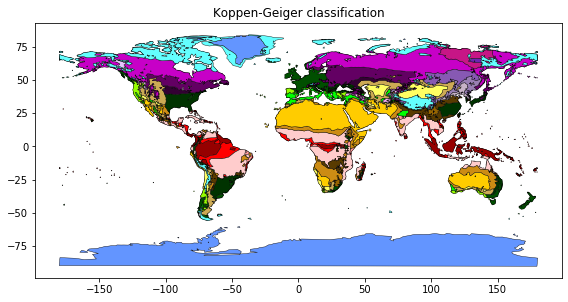

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
for label in np.unique(koppen_zones['LABEL']):
    color=climate_color_dict[label]
    koppen_zones.loc[koppen_zones['LABEL']==label].plot(ax=ax,edgecolor='black',linewidth=0.4,
                                                  facecolor=color)
ax.set(title='Koppen-Geiger classification')
fig.tight_layout()
plt.show()

# Assign each basin to its climate zone

We upload basins data and set the longitude/latitude projection (`epsg=4326`).

In [17]:
basins=geopandas.read_file("../datasets/basins/basins.shp")
basins.crs = 'epsg:4326'
basins

,NAME,CONTINENT,OCEAN,RASTAREA,geometry
0,WINISK,"North America, Central America and the Caribbean",Arctic Ocean,65635.3,"POLYGON ((-87.24167 52.32500, -87.24223 52.314..."
1,COPPER,"North America, Central America and the Caribbean",Pacific Ocean,65704.3,"POLYGON ((-140.15833 61.00000, -140.15890 60.9..."
2,NOTTAWAY,"North America, Central America and the Caribbean",Arctic Ocean,66053.1,"MULTIPOLYGON (((-73.85417 50.00833, -73.85089 ..."
3,TALAS,Asia,---,66179.8,"POLYGON ((73.61250 42.33333, 73.60612 42.33277..."
4,MARONI,South America,Atlantic Ocean,66408.4,"POLYGON ((-53.08750 3.20833, -53.08508 3.20798..."
...,...,...,...,...,...
184,Tibetan plateau,Asia,---,590841.4,"POLYGON ((91.41667 35.80000, 91.51172 35.76596..."
185,Western Plateau,South-West Pacific,---,1998005.0,"POLYGON ((134.56667 -16.38750, 134.62917 -16.4..."
186,Puna de Atacama plateau,South America,---,101842.2,"MULTIPOLYGON (((-68.88750 -26.79167, -68.83750..."
187,Salinas Grandes,South America,---,155116.8,"POLYGON ((-66.62500 -26.12500, -66.57500 -26.1..."


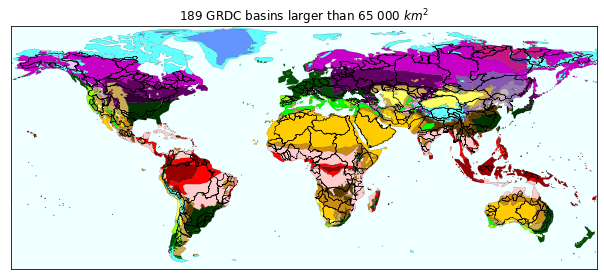

In [18]:
fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
for label in np.unique(koppen_zones['LABEL']):
    color=climate_color_dict[label]
    koppen_zones.loc[koppen_zones['LABEL']==label].plot(ax=ax,edgecolor='black',linewidth=0.1,
                                                  facecolor=color)
basins.boundary.plot(ax=ax,color='black',linewidth=0.5)
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('{} GRDC basins larger than 65 000 $km^2$'.format(basins.shape[0]))
plt.tight_layout()
plt.show()

For a given basin, we look at all the climate zones covering it.

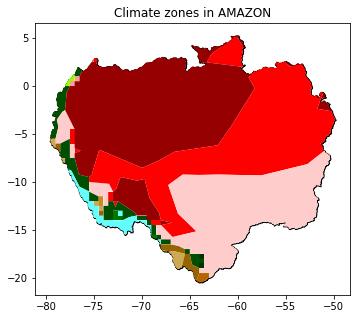

In [19]:
basin_name='AMAZON'

intersec=geopandas.overlay(koppen_zones, basins.loc[basins['NAME']==basin_name], how='intersection')

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
basins.loc[basins['NAME']==basin_name].plot(ax=ax, color='white', edgecolor='black')
intersec.loc[intersec['NAME']==basin_name].plot(ax=ax,color=intersec['COLOR_HEX'])
plt.title("Climate zones in {}".format(basin_name))
plt.show()

For each basin, we compute the area of each climate zone and add the largest to the database.

In [20]:
# geometric intersection between climate zones and the basin
intersec=geopandas.overlay(koppen_zones[['geometry','LABEL','COLOR_HEX']], 
                           basins[['NAME','RASTAREA','geometry']], how='intersection')

# intersection creates multiple polygons that need to be assembled
intersec_meter=intersec.dissolve(by=['NAME','LABEL']).copy()

# projection to meters
intersec_meter=intersec_meter.to_crs('epsg:6933')

# area of the intersection (converted to km2)
intersec_meter['AREA']=intersec_meter['geometry'].area/1e6

# some areas are slightly larger than the one saved in the database, this is corrected
intersec_meter['AREA']=np.where(intersec_meter['AREA']>intersec_meter['RASTAREA'],intersec_meter['RASTAREA'],intersec_meter['AREA'])

# percentage area of each climate zone
intersec_meter['CLIMATE_AREA_%']=100*intersec_meter['AREA']/intersec_meter['RASTAREA']

# save labels in a separate column
intersec_meter['MAIN_CLIMATE']=intersec_meter.index.to_frame()['LABEL']

# keep labels with the largest area
intersec_meter.index=intersec_meter.index.droplevel(1)
intersec_max=intersec_meter.groupby('NAME')['CLIMATE_AREA_%'].max()
intersec_meter['largest area']=intersec_max
intersec_meter=intersec_meter.loc[intersec_meter['CLIMATE_AREA_%']==intersec_meter['largest area']]
intersec_meter.drop('largest area',axis=1,inplace=True)

# assign values
basins2=basins.join(intersec_meter[['MAIN_CLIMATE','CLIMATE_AREA_%','COLOR_HEX']],on='NAME')

Number of basins in each climate zone

In [21]:
basins2.groupby('MAIN_CLIMATE').count()['NAME']

MAIN_CLIMATE
Af      9
Am      1
As      2
Aw     27
BSh    17
BSk    14
BWh    25
BWk     3
Cfa    10
Cfb    10
Csa     2
Csb     5
Cwa     7
Dfa     1
Dfb    13
Dfc    29
Dfd     4
Dwa     1
Dwb     1
Dwc     2
ET      6
Name: NAME, dtype: int64

Gather similar climate with only 1 basin

In [22]:
if ~approximate:
    basins2['MAIN_CLIMATE'].replace('As','Asw',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Aw','Asw',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Af','Afm',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Am','Afm',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Cfa','Cf',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Cfb','Cf',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Cfc','Cf',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Csa','Cs',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Csb','Cs',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Csc','Cs',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Dfa','Dfb',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Dwa','Dw',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Dwb','Dw',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Dwc','Dw',inplace=True)
    basins2['MAIN_CLIMATE'].replace('Dwd','Dw',inplace=True)

We plot all river basins covered by a single climate zone over at least `threshold` percents. I don'k know how to map colors when some colors of the paletteare missing because the climate zone associated is not represented => need to use the color column.

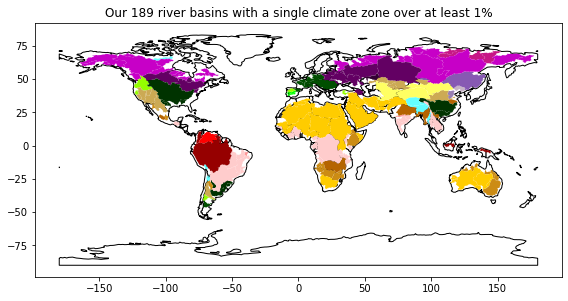

In [23]:
from matplotlib.colors import Normalize

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
threshold=1
selected_basins=basins2.loc[basins2['CLIMATE_AREA_%']>=threshold]

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
# this code works if all climate zones are represented in selected_basins
#selected_basins.plot(ax=ax, column='MAIN_CLIMATE', categorical=True,
#             legend=True, cmap=ListedColormap(color_array),norm=norm,
#            legend_kwds={'bbox_to_anchor':(1.25,1.0),'ncol':2,'fontsize':'x-small'})

selected_basins.plot(ax=ax, color=selected_basins['COLOR_HEX'], categorical=True,
             legend=True,legend_kwds={'bbox_to_anchor':(1.25,1.0),'ncol':2,'fontsize':'x-small'})
plt.title("Our {} river basins with a single climate zone over at least {}%".format(selected_basins.shape[0],threshold))
plt.tight_layout()
plt.show()

Save data

In [24]:
if approximate:
    basins2.to_file("../datasets/basins/basins_with_approx_climate_zones.shp")
else:
    basins2.to_file("../datasets/basins/basins_with_climate_zones.shp")